In [49]:
# !pip install arcgis

In [50]:
"""Plague Classification Model with ArcGIS Data"""

import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory
from arcgis.gis import GIS
from PIL import Image
import logging
import time
from concurrent.futures import ThreadPoolExecutor, as_completed


In [51]:
# import os
# import logging
# import time
# from PIL import Image
# from arcgis.gis import GIS

# # Configuración básica de logging
# logging.basicConfig(
#     filename='descarga_arcgis.log',
#     filemode='a',
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     level=logging.INFO
# )

# # Conexión a ArcGIS Online o Enterprise
# try:
#     gis = GIS("https://arcgismaps.pantaleon.com/portal", "uvg_2024", "Inicio2024.")
#     logging.info("Conexión a ArcGIS establecida exitosamente.")
# except Exception as e:
#     logging.error(f"Error al conectar a ArcGIS: {e}")
#     raise SystemExit(f"Error al conectar a ArcGIS: {e}")

# # Encuentra el elemento Survey123 por su ID
# survey_id = "e9eff4bf0dff4d199ff5b889d8fd7980"  # Reemplaza con el ID real de tu Survey
# survey = gis.content.get(survey_id)
# if not survey:
#     logging.error(f"No se encontró el Survey con ID: {survey_id}")
#     raise SystemExit(f"No se encontró el Survey con ID: {survey_id}")
# logging.info(f"Survey encontrado: {survey.title}")

# # Identificar la capa correcta basada en un campo específico
# nombre_campo_clave = 'clasificacion'  # Reemplaza con un campo específico de tu formulario

# capas = survey.layers
# capa_correcta = None

# for capa in capas:
#     nombres_campos = [campo['name'] for campo in capa.properties.fields]
#     if nombre_campo_clave in nombres_campos:
#         capa_correcta = capa
#         break

# if capa_correcta:
#     feature_layer = capa_correcta
#     logging.info(f"Usando la capa: {feature_layer.properties.name}")
# else:
#     logging.error(f"No se encontró una capa que contenga el campo '{nombre_campo_clave}'.")
#     raise SystemExit(f"No se encontró una capa que contenga el campo '{nombre_campo_clave}'.")

# # Función para verificar si un adjunto es una imagen
# def is_image_attachment(attachment):
#     return attachment['contentType'].lower() in [
#         'image/png',
#         'image/jpeg',
#         'image/jpg',
#         'image/gif',
#         'image/bmp',
#         'image/tiff'
#     ]

# # Función para redimensionar las imágenes
# def resize_image(image_path, size=(128, 128)):
#     try:
#         with Image.open(image_path) as img:
#             img = img.resize(size)
#             img.save(image_path)
#         logging.info(f"Imagen redimensionada: {image_path}")
#     except Exception as e:
#         logging.error(f"Error al redimensionar la imagen {image_path}: {e}")

# # Directorio base para almacenar las imágenes descargadas
# base_images_dir = "arcgis-survey-images"
# os.makedirs(base_images_dir, exist_ok=True)
# logging.info(f"Directorio base para imágenes: {base_images_dir}")

# # Lista para almacenar errores
# errores = []

# # Función para generar un nombre de archivo único basado en object_id y attachment_id
# def generar_nombre_unico(attachment_name, object_id, attachment_id):
#     name, ext = os.path.splitext(attachment_name)
#     # Sanitizar el nombre del archivo para evitar caracteres inválidos
#     name = "".join([c for c in name if c.isalpha() or c.isdigit() or c in (' ', '_', '-')]).rstrip()
#     # Puedes personalizar el formato del nombre según tus necesidades
#     nombre_unico = f"{name}_OID{object_id}_ATT{attachment_id}{ext}"
#     return nombre_unico

# # Función para obtener un nombre de archivo único si ya existe
# def get_unique_filename(file_path):
#     if not os.path.exists(file_path):
#         return file_path
#     else:
#         base, extension = os.path.splitext(file_path)
#         i = 1
#         new_file_path = f"{base}({i}){extension}"
#         while os.path.exists(new_file_path):
#             i += 1
#             new_file_path = f"{base}({i}){extension}"
#         return new_file_path

# # Función para procesar y descargar una imagen
# def procesar_descargar_imagen(feature, attachment):
#     # Ajustar los nombres de los campos según tu data
#     object_id = feature.attributes.get('objectid') or feature.attributes.get('OBJECTID') or feature.attributes.get('ObjectID')
#     if object_id is None:
#         logging.error("No se encontró el campo 'objectid' en los atributos de la feature.")
#         errores.append((None, attachment['name'], "Campo 'objectid' no encontrado"))
#         return
#     classification = feature.attributes.get('clasificacion') or feature.attributes.get('Clasificacion') or 'SinClasificacion'

#     # Crear un directorio para la clasificación si no existe
#     class_dir = os.path.join(base_images_dir, str(classification))
#     os.makedirs(class_dir, exist_ok=True)

#     if is_image_attachment(attachment):
#         # Generar un nombre único para cada imagen
#         image_filename = generar_nombre_unico(attachment['name'], object_id, attachment['id'])
#         image_path = os.path.join(class_dir, image_filename)

#         try:
#             # Descargar el adjunto a la carpeta con el nombre original
#             feature_layer.attachments.download(
#                 oid=object_id,
#                 attachment_id=attachment['id'],
#                 save_path=class_dir
#                 # No se utiliza file_name aquí
#             )
#             logging.info(f"Descargada imagen a {class_dir}")
            
#             # El archivo descargado se llama attachment['name']
#             downloaded_path = os.path.join(class_dir, attachment['name'])
            
#             # Verificar si el archivo descargado existe
#             if not os.path.exists(downloaded_path):
#                 logging.error(f"El archivo descargado no existe: {downloaded_path}")
#                 errores.append((object_id, attachment['name'], "Archivo descargado no encontrado"))
#                 return
            
#             # Verificar si el archivo único ya existe y obtener un nombre único
#             if os.path.exists(image_path):
#                 original_image_path = image_path
#                 image_path = get_unique_filename(image_path)
#                 logging.warning(f"El archivo {original_image_path} ya existía. Se guardará como {os.path.basename(image_path)}")
            
#             # Renombrar el archivo descargado a la ruta con el nombre único
#             os.rename(downloaded_path, image_path)
#             logging.info(f"Imagen renombrada a {image_path}")

#             # Redimensionar la imagen
#             resize_image(image_path)
#         except Exception as e:
#             logging.error(f"Error al descargar o procesar la imagen {attachment['name']} para el object_id {object_id}: {e}")
#             errores.append((object_id, attachment['name'], str(e)))

# # Función para obtener todas las features utilizando object IDs
# def get_all_features(layer):
#     all_features = []
#     try:
#         # Obtener el campo de Object ID
#         object_id_field = layer.properties.objectIdField
#         oid_info = layer.query(return_ids_only=True)
#         object_ids = oid_info['objectIds']
#         if not object_ids:
#             logging.error("No se pudieron obtener los Object IDs.")
#             return []
#         total = len(object_ids)
#         logging.info(f"Total de features disponibles: {total}")

#         # Procesar los Object IDs en lotes
#         batch_size = 1000  # Puedes ajustar este valor según tus necesidades
#         for i in range(0, total, batch_size):
#             batch_ids = object_ids[i:i + batch_size]
#             where_clause = f"{object_id_field} IN ({', '.join(map(str, batch_ids))})"
#             query_result = layer.query(where=where_clause, out_fields='*')
#             all_features.extend(query_result.features)
#             logging.info(f"Recuperados {len(all_features)} de {total} features...")
#     except Exception as e:
#         logging.error(f"Error al obtener las features: {e}")
#         raise
#     return all_features

# # Descargar imágenes desde Survey123 y organizar en carpetas según la clasificación
# try:
#     all_features = get_all_features(feature_layer)
#     total_features = len(all_features)
#     logging.info(f"Total de features obtenidos: {total_features}")
# except Exception as e:
#     logging.error(f"Error al realizar la consulta a la capa: {e}")
#     raise SystemExit(f"Error al realizar la consulta a la capa: {e}")

# # Descargar todas las imágenes secuencialmente
# for feature in all_features:
#     object_id = feature.attributes.get('objectid') or feature.attributes.get('OBJECTID') or feature.attributes.get('ObjectID')
#     if object_id is None:
#         logging.error("No se encontró el campo 'objectid' en los atributos de la feature.")
#         errores.append((None, None, "Campo 'objectid' no encontrado"))
#         continue
#     attachments = feature_layer.attachments.get_list(oid=object_id)
#     if not attachments:
#         logging.info(f"No se encontraron adjuntos para el object_id: {object_id}")
#         continue
#     for attachment in attachments:
#         procesar_descargar_imagen(feature, attachment)
#         # Implementar una pequeña pausa para evitar posibles límites de la API
#         time.sleep(0.05)  # Pausa de 50 ms

# logging.info("Descarga de imágenes completada.")

# # Mostrar errores si los hay
# if errores:
#     logging.warning(f"Total de errores: {len(errores)}")
#     for oid, nombre, error in errores:
#         logging.warning(f"Object ID {oid}, Archivo {nombre}: {error}")
# else:
#     logging.info("No se encontraron errores durante la descarga.")

# # Verificar la integridad de las imágenes descargadas
# total_descargadas = 0
# for root, dirs, files in os.walk(base_images_dir):
#     for file in files:
#         if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
#             total_descargadas += 1

# logging.info(f"Total de imágenes descargadas: {total_descargadas}")
# print(f"Imágenes descargadas y organizadas por clasificación en: {base_images_dir}")
# print(f"Total de imágenes descargadas: {total_descargadas}")

# # Mostrar errores en la consola
# if errores:
#     print(f"\nTotal de errores durante la descarga: {len(errores)}")
#     for oid, nombre, error in errores:
#         print(f"Object ID {oid}, Archivo {nombre}: {error}")
# else:
#     print("\nNo se encontraron errores durante la descarga.")


In [52]:
# # Configuración básica de logging
# logging.basicConfig(
#     filename='descarga_arcgis.log',
#     filemode='a',
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     level=logging.INFO
# )

In [53]:
# # Conexión a ArcGIS Online o Enterprise
# try:
#     gis = GIS("https://arcgismaps.pantaleon.com/portal", "uvg_2024", "Inicio2024.")
#     logging.info("Conexión a ArcGIS establecida exitosamente.")
# except Exception as e:
#     logging.error(f"Error al conectar a ArcGIS: {e}")
#     raise SystemExit(f"Error al conectar a ArcGIS: {e}")

In [54]:
# # Encuentra el elemento Survey123 por su ID
# survey_id = "e9eff4bf0dff4d199ff5b889d8fd7980"  # Reemplaza con el ID real de tu Survey
# survey = gis.content.get(survey_id)
# if not survey:
#     logging.error(f"No se encontró el Survey con ID: {survey_id}")
#     raise SystemExit(f"No se encontró el Survey con ID: {survey_id}")
# logging.info(f"Survey encontrado: {survey.title}")

# feature_layer = survey.layers[0]  # Capa que contiene las respuestas
# print(feature_layer)

In [55]:
# # Función para verificar si un adjunto es una imagen
# def is_image_attachment(attachment):
#     return attachment['contentType'].lower() in [
#         'image/png',
#         'image/jpeg',
#         'image/jpg',
#         'image/gif',
#         'image/bmp',
#         'image/tiff'
#     ]

In [56]:
# # Función para redimensionar las imágenes
# def resize_image(image_path, size=(128, 128)):
#     try:
#         with Image.open(image_path) as img:
#             img = img.resize(size)
#             img.save(image_path)
#         logging.info(f"Imagen redimensionada: {image_path}")
#     except Exception as e:
#         logging.error(f"Error al redimensionar la imagen {image_path}: {e}")


In [57]:
# # Directorio base para almacenar las imágenes descargadas
# base_images_dir = "arcgis-survey-images"
# os.makedirs(base_images_dir, exist_ok=True)
# logging.info(f"Directorio base para imágenes: {base_images_dir}")

# # Diccionario para almacenar las imágenes duplicadas
# duplicated_images = {}

# # Lista para almacenar errores
# errores = []

In [58]:
# # Función para generar un nuevo nombre de archivo para duplicados
# def generate_unique_filename(base_path):
#     name, ext = os.path.splitext(base_path)
#     counter = 1
#     new_path = base_path
#     while os.path.exists(new_path):
#         new_path = f"{name}({counter}){ext}"
#         counter += 1
#     return new_path

In [59]:
# # Función para procesar y descargar una imagen
# def procesar_descargar_imagen(feature, attachment):
#     object_id = feature.attributes.get('objectid')
#     classification = feature.attributes.get('clasificacion', 'SinClasificacion')
    
#     # Crear un directorio para la clasificación si no existe
#     class_dir = os.path.join(base_images_dir, str(classification))
#     os.makedirs(class_dir, exist_ok=True)
    
#     if is_image_attachment(attachment):
#         original_path = os.path.join(class_dir, attachment['name'])
#         image_path = generate_unique_filename(original_path)
        
#         # Registrar si es una imagen duplicada
#         if image_path != original_path:
#             if original_path not in duplicated_images:
#                 duplicated_images[original_path] = [image_path]
#             else:
#                 duplicated_images[original_path].append(image_path)
        
#         try:
#             logging.info(f"Descargando imagen {os.path.basename(image_path)} para el object_id: {object_id}")
#             feature_layer.attachments.download(
#                 oid=object_id,
#                 attachment_id=attachment['id'],
#                 save_path=os.path.dirname(image_path)
#             )
#             # Renombrar el archivo descargado si es necesario
#             downloaded_path = os.path.join(os.path.dirname(image_path), attachment['name'])
#             if downloaded_path != image_path:
#                 os.rename(downloaded_path, image_path)
#                 logging.info(f"Imagen renombrada a {image_path}")
            
#             # Redimensionar la imagen
#             resize_image(image_path)
#         except Exception as e:
#             logging.error(f"Error al descargar o procesar la imagen {attachment['name']} para el object_id {object_id}: {e}")
#             errores.append((object_id, attachment['name'], str(e)))

In [60]:
# # Descargar imágenes desde Survey123 y organizar en carpetas según la clasificación
# try:
#     query_result = feature_layer.query(return_all=True)
#     total_features = len(query_result.features)
#     logging.info(f"Total de features obtenidos: {total_features}")
# except Exception as e:
#     logging.error(f"Error al realizar la consulta a la capa: {e}")
#     raise SystemExit(f"Error al realizar la consulta a la capa: {e}")


In [61]:
# # Parámetros para descarga en paralelo
# max_workers = 10  # Puedes ajustar este número según los recursos de tu sistema y límites de la API
# with ThreadPoolExecutor(max_workers=max_workers) as executor:
#     futuros = []
#     for feature in query_result.features:
#         object_id = feature.attributes.get('objectid')
#         attachments = feature_layer.attachments.get_list(oid=object_id)
#         if not attachments:
#             logging.info(f"No se encontraron adjuntos para el object_id: {object_id}")
#             continue
#         for attachment in attachments:
#             futuros.append(executor.submit(procesar_descargar_imagen, feature, attachment))
#             # Implementar una pequeña pausa para evitar posibles límites de la API
#             time.sleep(0.05)  # Pausa de 50 ms
    
#     # Monitorear el progreso
#     for futuro in as_completed(futuros):
#         pass  # Aquí podrías implementar seguimiento si lo deseas

# logging.info("Descarga de imágenes completada.")

In [62]:
# # Identificar la capa correcta basada en un campo específico
# nombre_campo_clave = 'clasificacion'  # Reemplaza con un campo específico de tu formulario

# capas = survey.layers
# capa_correcta = None

# for capa in capas:
#     nombres_campos = [campo['name'] for campo in capa.properties.fields]
#     if nombre_campo_clave in nombres_campos:
#         capa_correcta = capa
#         break

# if capa_correcta:
#     feature_layer = capa_correcta
#     print(f"Usando la capa: {feature_layer.properties.name}")
# else:
#     logging.error(f"No se encontró una capa que contenga el campo '{nombre_campo_clave}'.")
#     raise SystemExit(f"No se encontró una capa que contenga el campo '{nombre_campo_clave}'.")

In [63]:
# # Mostrar listado de imágenes duplicadas
# if duplicated_images:
#     logging.info("Listado de imágenes duplicadas:")
#     for original, duplicates in duplicated_images.items():
#         logging.info(f"Original: {original}")
#         for dup in duplicates:
#             logging.info(f"  Duplicado: {dup}")
# else:
#     logging.info("No se encontraron imágenes duplicadas.")

# # Mostrar errores si los hay
# if errores:
#     logging.warning(f"Total de errores: {len(errores)}")
#     for oid, nombre, error in errores:
#         logging.warning(f"Object ID {oid}, Archivo {nombre}: {error}")
# else:
#     logging.info("No se encontraron errores durante la descarga.")

# # Verificar la integridad de las imágenes descargadas
# total_descargadas = 0
# for root, dirs, files in os.walk(base_images_dir):
#     for file in files:
#         if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
#             total_descargadas += 1

# logging.info(f"Total de imágenes descargadas: {total_descargadas}")
# print(f"Imágenes descargadas y organizadas por clasificación en: {base_images_dir}")
# print(f"Total de imágenes descargadas: {total_descargadas}")

# # Mostrar listado de imágenes duplicadas en la consola
# if duplicated_images:
#     print("\nListado de imágenes duplicadas:")
#     for original, duplicates in duplicated_images.items():
#         print(f"Original: {original}")
#         for dup in duplicates:
#             print(f"  Duplicado: {dup}")
# else:
#     print("\nNo se encontraron imágenes duplicadas.")

# # Mostrar errores en la consola
# if errores:
#     print(f"\nTotal de errores durante la descarga: {len(errores)}")
#     for oid, nombre, error in errores:
#         print(f"Object ID {oid}, Archivo {nombre}: {error}")
# else:
#     print("\nNo se encontraron errores durante la descarga.")

In [64]:
# import os

# # Diccionario para almacenar las imágenes duplicadas
# duplicated_images = {}

# # Función para generar un nuevo nombre de archivo para duplicados
# def generate_unique_filename(base_path, filename):
#     name, ext = os.path.splitext(filename)
#     counter = 1
#     new_path = base_path
#     while os.path.exists(new_path):
#         new_path = os.path.join(os.path.dirname(base_path), f"{name}({counter}){ext}")
#         counter += 1
#     return new_path

# # Descargar imágenes desde Survey123 y organizar en carpetas según la clasificación
# for feature in feature_layer.query().features:
#     try:
#         object_id = feature.attributes['objectid']
#         classification = feature.attributes['clasificacion']  # Clasificación de la plaga

#         # Crear un directorio para la clasificación si no existe
#         class_dir = os.path.join(base_images_dir, classification)
#         if not os.path.exists(class_dir):
#             os.makedirs(class_dir)
        
#         # Descargar los adjuntos (imágenes) para el object_id
#         attachments = feature_layer.attachments.get_list(oid=object_id)
#         if not attachments:
#             print(f"No se encontraron adjuntos para el object_id: {object_id}")
        
#         for attachment in attachments:
#             if is_image_attachment(attachment):
#                 original_path = os.path.join(class_dir, attachment['name'])
                
#                 # Generar un nombre único si la imagen ya existe
#                 image_path = generate_unique_filename(original_path, attachment['name'])
                
#                 # Registrar si es una imagen duplicada
#                 if image_path != original_path:
#                     if original_path not in duplicated_images:
#                         duplicated_images[original_path] = [image_path]
#                     else:
#                         duplicated_images[original_path].append(image_path)
                
#                 print(f"Descargando imagen {os.path.basename(image_path)} para el object_id: {object_id}")
#                 feature_layer.attachments.download(oid=object_id, attachment_id=attachment['id'], save_path=os.path.dirname(image_path))
#                 os.rename(os.path.join(os.path.dirname(image_path), attachment['name']), image_path)
#                 resize_image(image_path)
        
#     except Exception as e:
#         print(f"Error al procesar el object_id {object_id}: {e}")

# print(f"Imágenes descargadas y organizadas por clasificación en: {base_images_dir}")

# # Mostrar listado de imágenes duplicadas
# if duplicated_images:
#     print("\nListado de imágenes duplicadas:")
#     for original, duplicates in duplicated_images.items():
#         print(f"Original: {original}")
#         for dup in duplicates:
#             print(f"  Duplicado: {dup}")
# else:
#     print("\nNo se encontraron imágenes duplicadas.")

In [65]:
# Parámetros de la red
EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
SEED = 123
BATCH_SIZE = 32
BUFFER_SIZE = 250
LEARNING_RATE = 0.001


images_dir = 'arcgis-survey-images'

In [66]:
# Cargar dataset de imágenes
train_ds = image_dataset_from_directory(
    images_dir,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    shuffle=True
)

validation_ds = image_dataset_from_directory(
    images_dir,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED
)

Found 3289 files belonging to 5 classes.
Using 2632 files for training.
Found 3289 files belonging to 5 classes.
Using 657 files for validation.


In [67]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [68]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [69]:
class_names = train_ds.class_names

In [70]:
# Primero, contamos cuántos ejemplos tiene cada clase
class_counts = train_ds.reduce(
    tf.constant([0, 0, 0, 0, 0], dtype=tf.int64), 
    lambda counts, batch: counts + tf.cast(tf.math.bincount(batch[1], minlength=5), dtype=tf.int64)
)

In [71]:

# Obtenemos el número máximo de ejemplos
max_count = tf.reduce_max(class_counts).numpy()

In [72]:
# Función para aplicar augmentación a las clases minoritarias
def augment_minority_class(x, y):
    augmented_x = x
    # Convertimos y a int32 para asegurar que funcione bien en TensorFlow
    y_int = tf.cast(y, tf.int32)
    
    # Usamos tf.gather para obtener los valores de class_counts correspondientes a las etiquetas
    class_count_for_y = tf.gather(class_counts, y_int)
    
    # Aplicamos augmentación si el número de ejemplos para la clase es menor al máximo
    should_augment = tf.less(class_count_for_y, max_count)
    
    # Si should_augment es True, aplica augmentación; si no, deja la imagen como está
    augmented_x = tf.cond(tf.reduce_any(should_augment), lambda: data_augmentation(x, training=True), lambda: x)

    return augmented_x, y



In [73]:

# Aplicamos data augmentation a las clases minoritarias
augmented_train_ds = train_ds.map(lambda x, y: augment_minority_class(x, y))



In [74]:
# Finalmente, seguimos con el procesamiento normal de cache y prefetch
augmented_train_ds = augmented_train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [75]:
# Cache y prefetch para mejorar rendimiento
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [76]:
# Cargar el modelo base (MobileNetV2) 
from tensorflow.keras.applications import MobileNetV2

In [77]:
base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                         include_top=False,
                         weights='imagenet')

In [78]:
# Ajuste de las capas del modelo base
for layer in base_model.layers[:100]:  # Ajusta según sea necesario
    layer.trainable = False

In [79]:
# Definir el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(class_names))
])


In [80]:
# Compilar el modelo
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

In [81]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [82]:
# Entrenamiento del modelo
history = model.fit(
    augmented_train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 47s 326ms/step - accuracy: 0.5597 - loss: 2.3588 - val_accuracy: 0.3912 - val_loss: 3.8428
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 284ms/step - accuracy: 0.8342 - loss: 1.1907 - val_accuracy: 0.4155 - val_loss: 2.4400
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 0.8610 - loss: 0.8174 - val_accuracy: 0.3744 - val_loss: 6.2858
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 283ms/step - accuracy: 0.8756 - loss: 0.6356 - val_accuracy: 0.4871 - val_loss: 3.9235
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 23s 283ms/step - accuracy: 0.9210 - loss: 0.3931 - val_accuracy: 0.5342 - val_loss: 2.9157
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 283ms/step - accuracy: 0.9331 - loss: 0.3326 - val_accuracy: 0.6149 - val_loss: 2.9114
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 284ms/step - accuracy: 0.9421 - loss: 0.2519 - val_accuracy: 0.7230 - val_loss: 2.8761
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - accuracy: 0.9462 - loss: 0.2298 - val_accu

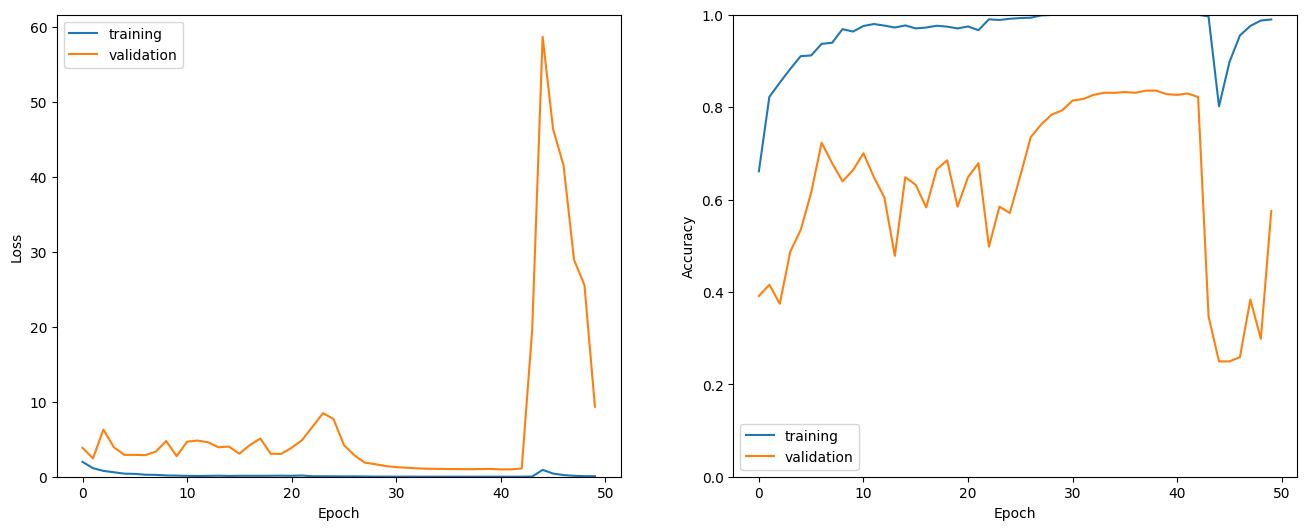

In [83]:
# Gráfica de la pérdida y precisión
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [84]:
# Evaluación en el conjunto de test
test_ds = validation_ds.shard(num_shards=2, index=1)
test_results = model.evaluate(test_ds, return_dict=True)
print("Resultados de evaluación en test set:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.5580 - loss: 10.3301
Resultados de evaluación en test set:
accuracy: 0.5688
loss: 10.1107


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step


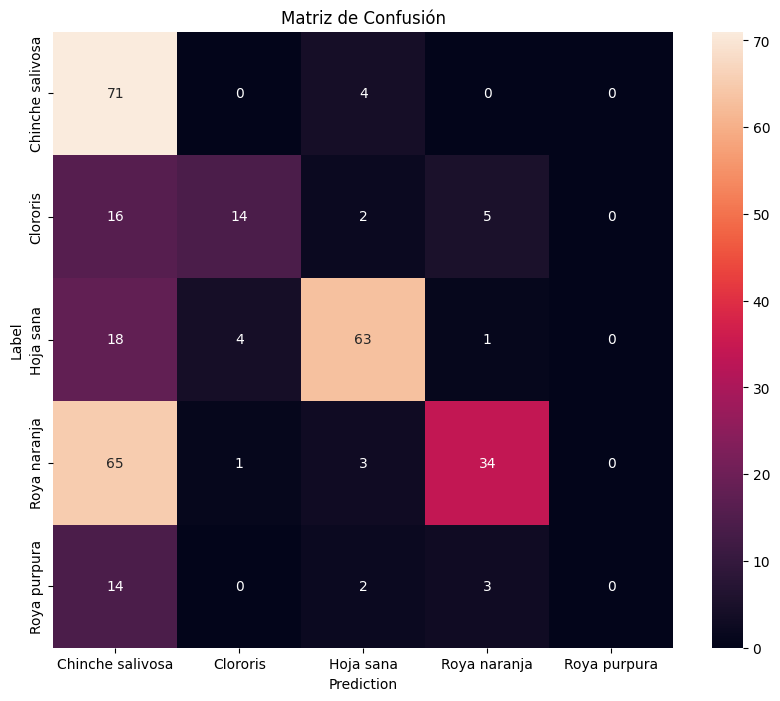

In [85]:
# Matriz de confusión
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

conf_matrix = tf.math.confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Matriz de Confusión')
plt.show()


In [86]:
# Reporte de clasificación
from sklearn.metrics import classification_report
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Reporte de clasificación:
                  precision    recall  f1-score   support

Chinche salivosa       0.39      0.95      0.55        75
        Clororis       0.74      0.38      0.50        37
       Hoja sana       0.85      0.73      0.79        86
    Roya naranja       0.79      0.33      0.47       103
    Roya purpura       0.00      0.00      0.00        19

        accuracy                           0.57       320
       macro avg       0.55      0.48      0.46       320
    weighted avg       0.66      0.57      0.55       320



C:\Users\ealda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ealda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ealda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati